In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.optimize import fsolve
from scipy import stats
import scipy.stats
import statsmodels.api as sm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical data for NSE Nifty 50 index (^NSEI)
df = yf.download('^NSEI',end = "2023-12-31")

nse = df.copy()

df['Date'] = df.index
prices = df['Close'].values
log_returns = np.log(prices[1:] / prices[:-1])

df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate mean, variance, skewness, and kurtosis
mean = np.mean(log_returns)
var = np.var(log_returns)
skew = scipy.stats.skew(log_returns)
kurt = scipy.stats.kurtosis(log_returns)


[*********************100%%**********************]  1 of 1 completed


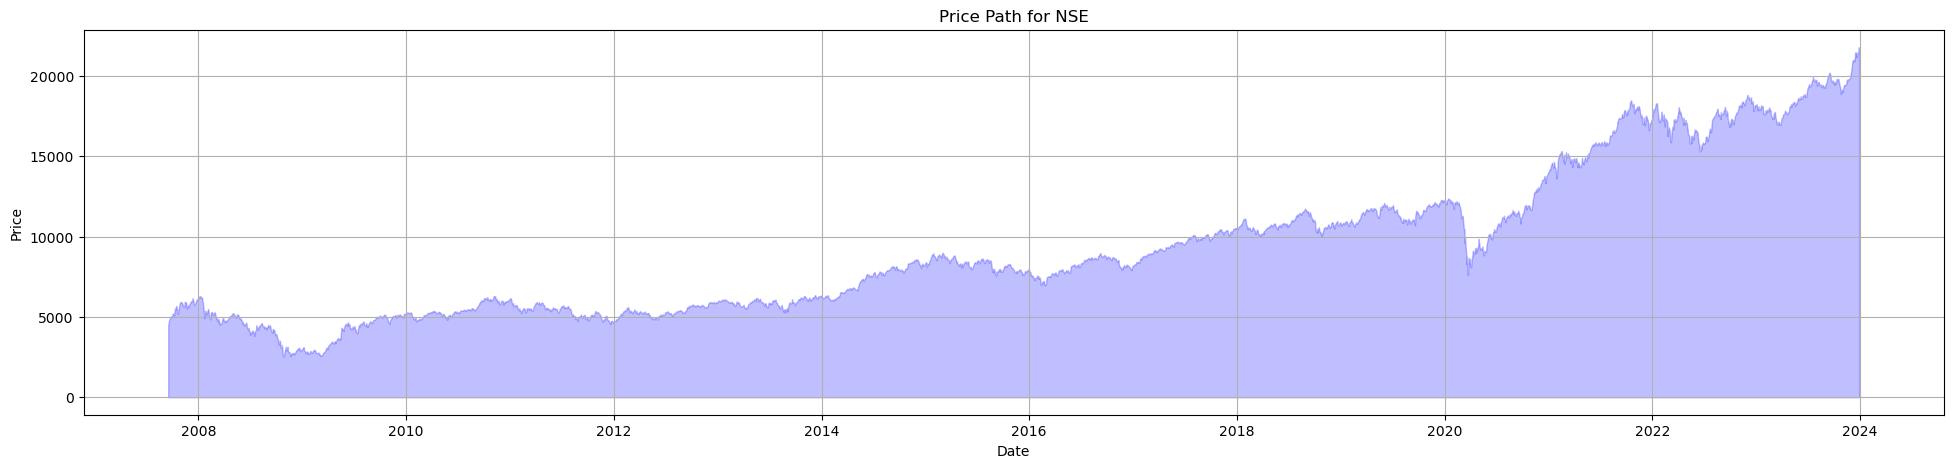

In [3]:
plt.figure(figsize=(24, 5))
plt.grid(visible=True)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Price Path for NSE")

plt.fill_between(df['Date'], df['Close'], color="blue", alpha=0.25)

plt.show()


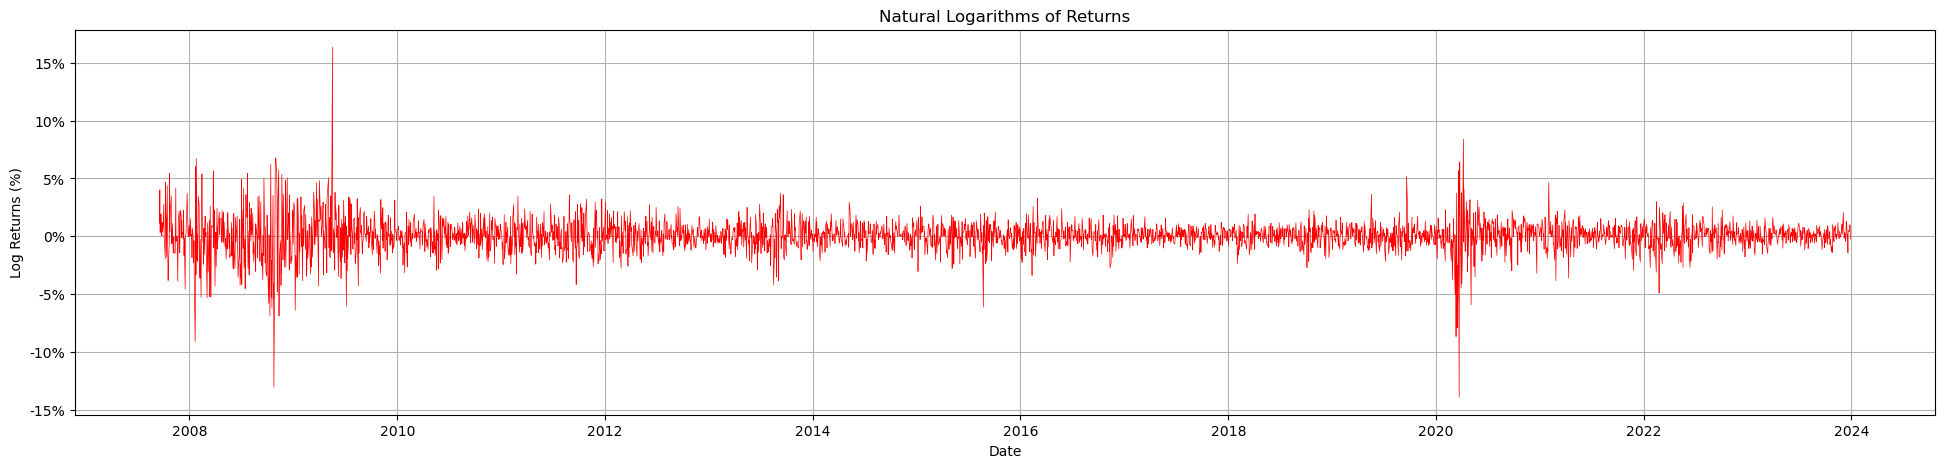

In [4]:
plt.figure(figsize=(24, 5))
plt.grid(visible=True)

plt.xlabel('Date')
plt.ylabel('Log Returns (%)')
plt.title("Natural Logarithms of Returns")

plt.plot(df['Date'], df['Log Returns'], color="red", linewidth=0.5)

plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])

plt.show()


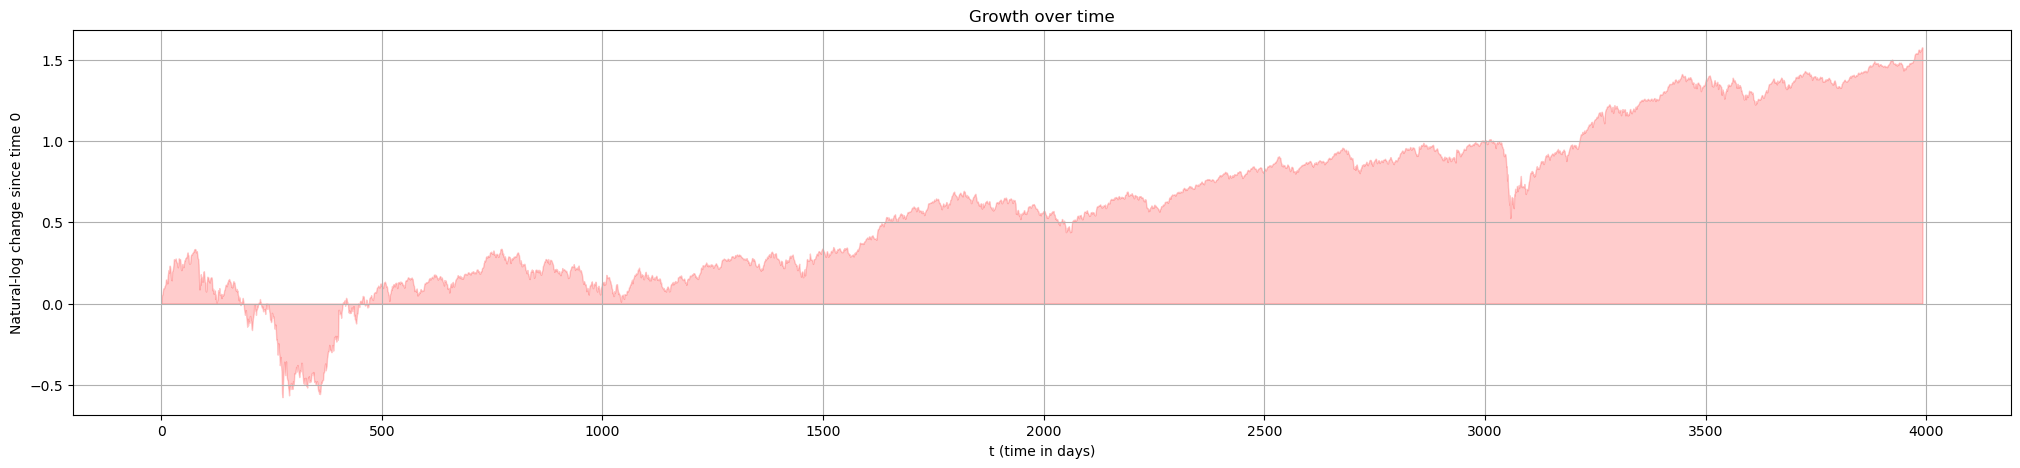

In [5]:
df['Xt'] = np.log(df['Close']) - np.log(df['Close'].iloc[0])

# Create a 't' column representing time
df['t'] = range(len(df))

# Plot the growth of Xt over time
plt.figure(figsize=(25, 5))
plt.grid(visible=True)
plt.xlabel('t (time in days)')
plt.ylabel('Natural-log change since time 0')

plt.title("Growth over time")
plt.fill_between(df['t'], df['Xt'], color="red", alpha=0.2)
plt.show()


To ensure a comprehensive analysis, we choose a highly composite number - 1890 - as our total number of observations.

This choice offers numerous factors, allowing for diverse time increments, denoted as 'delta_t'.

In [6]:
delta_t = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 18, 20, 21, 24, 27, 28, 30, 35, 36, 40, 42, 45, 54, 56, 60, 63, 70, 72, 84, 90, 105, 108, 120, 126, 135, 140, 168, 180, 189, 210, 216, 252, 270, 280, 315, 360, 378, 420, 504, 540, 630, 756, 840, 945, 1080, 1260, 1512, 1890)#, 2520, 3780)

# Printing the factors
print("Number of time increments ('delta_t') used in the analysis:", len(delta_t))


Number of time increments ('delta_t') used in the analysis: 61


Now, let's select the values of q - the statistical moments - for our partition function.

However, for our purposes, we'll simplify and treat all moments as 'raw' without normalization.

In [7]:
# Define the values of q
q = [0.01, 0.1, 0.25,
     0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,
     1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45,
     1.5, 1.55, 1.6, 1.65, 1.7,1.71,1.72,1.73,1.74, 1.75,1.76,1.77,1.78,1.79,
     1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89,
     1.9, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.985, 1.99,
     1.991, 1.992, 1.993, 1.994, 1.995, 1.996, 1.997, 1.998, 1.999,
     2.0,
     2.001, 2.002, 2.003, 2.004, 2.005, 2.006, 2.007, 2.008, 2.009,
     2.01, 2.015, 2.02, 2.025,
     2.03,2.035, 2.04,2.045, 2.05,2.055, 2.06, 2.065,2.07, 2.075,2.08, 2.085,2.09,2.095,
     2.1,2.11,2.12,2.13,2.14, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5,
     2.6, 2.7, 2.8, 2.9,
     3.0, 3.25, 3.5, 3.75,
     4.0,5.0, 10.0, 15.0, 20.0]

# Printing the number of q values
print("The number of q's to be used is", len(q))


The number of q's to be used is 121


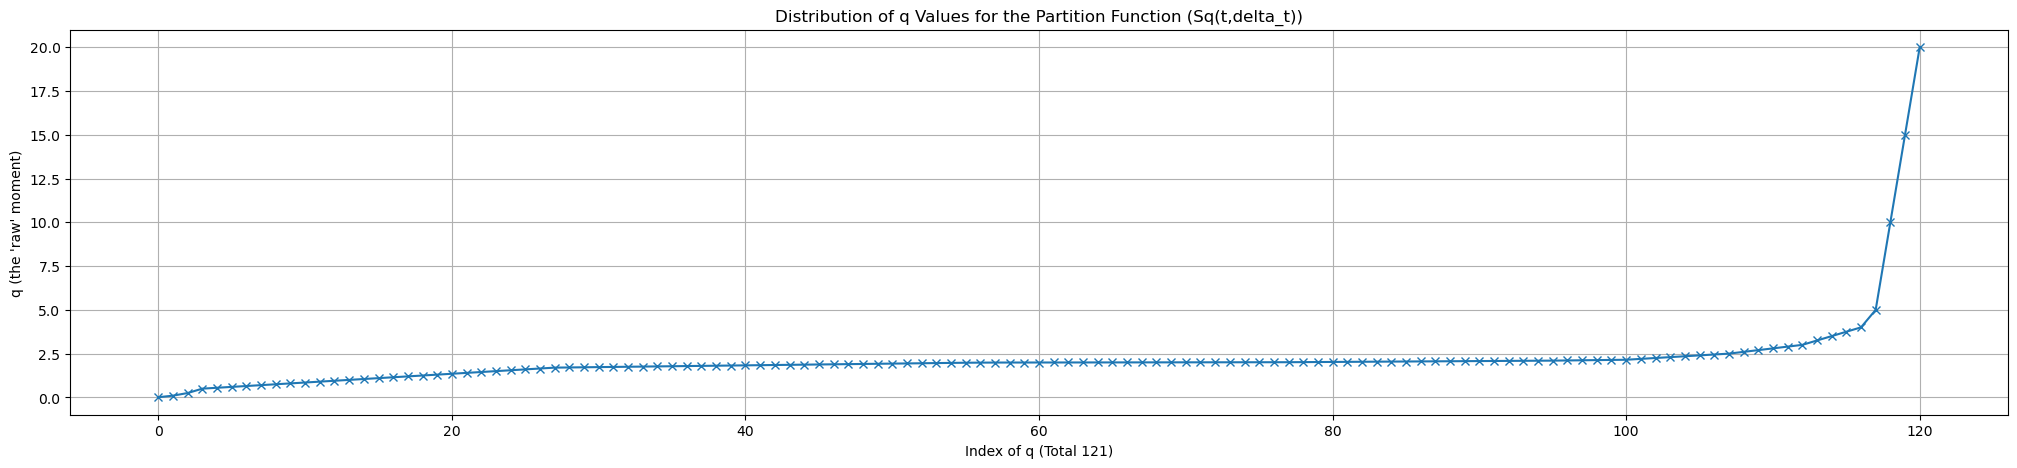

In [8]:
# Plotting the distribution of q values used for the Partition Function (Sq(t,delta_t))
plt.figure(figsize=(25, 5))
plt.grid(visible=True)

plt.title("Distribution of q Values for the Partition Function (Sq(t,delta_t))")
plt.xlabel("Index of q (Total {})".format(len(q)))
plt.ylabel("q (the 'raw' moment)")

# Plotting the q values
plt.plot(q, marker='x')


Let's calculate the partition function, Sq(T, delta_t), for various values of delta_t and q.

The partition function Sq(T, delta_t) will help us estimate the scaling function tau(q).

In [9]:
def partition_function(SIGMA, DELTA, XT, Q):
    SIGMA=[[0 for x in range(len(DELTA))] for y in range(len(Q))]
    for k in range (0, len(Q)):
        for j in range (0,len(DELTA)):
            for i in range (0,len(XT)-1):
                if i < int(len(XT)/DELTA[j]):
                    SIGMA[k][j] += abs(XT[i * DELTA[j] + DELTA[j]] - XT[i * DELTA[j]]) ** Q[k]
                    #SIGMA[k][j]=SIGMA[k][j] + abs(XT[i*DELTA[j]+DELTA[j]]-XT[i*DELTA[j]])**Q[k]


    SIGMA=pd.DataFrame(SIGMA)

    for i in range (0,len(Q)):
        SIGMA.rename(index={SIGMA.index[i]:Q[i]}, inplace=True)
    for i in range (len(DELTA)-1,-1,-1):
        SIGMA.rename(columns={SIGMA.columns[i]:DELTA[i]}, inplace=True)

    return SIGMA


print("\nHere we have defined our partition function in the form: \npartition_function(SIGMA, DELTA, XT, Q).")


Here we have defined our partition function in the form: 
partition_function(SIGMA, DELTA, XT, Q).


In [10]:
# Calculate Xt directly
df = df[-3781:]

partition_NSE=[[]]

partition_NSE=partition_function(partition_NSE, delta_t, df.Xt, q)

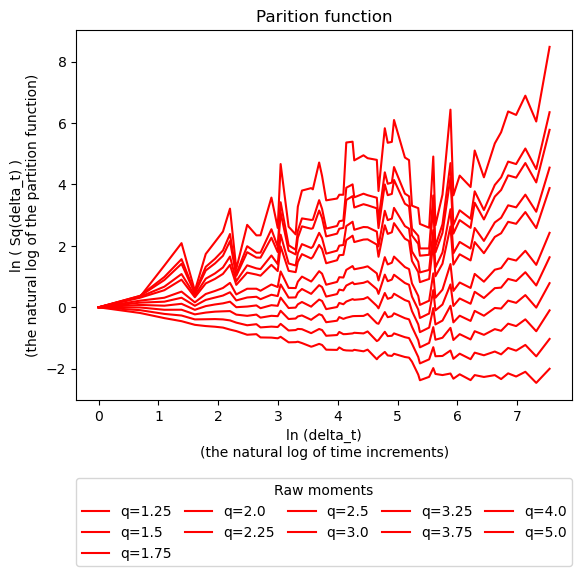

In [11]:
for i in range (0, len(q)):
    if q[i]%0.25==0 and q[i]<6 and q[i]>1 and q[i]!=3.5 and q[i]!=4.5:
        plt.plot(np.log(delta_t), np.log(list(partition_NSE.iloc[i])/partition_NSE[1][q[i]]), color="red", linewidth=1.5, label='q='+str(q[i]))


plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc=3,
           ncol=5, mode="expand", borderaxespad=0., title="Raw moments")

plt.title("Parition function")
plt.xlabel('ln (delta_t)\n(the natural log of time increments)')
plt.ylabel('ln ( Sq(delta_t) )\n(the natural log of the partition function)')

plt.show()

In [13]:
tau_regression=pd.DataFrame(np.log(delta_t))
tau_regression['LN_DELTA']=pd.DataFrame(np.log(delta_t))
tau_regression['LN_T']=[np.log(1890) for x in range(len(delta_t))]

def scaling_function(TAU_Q, PARTITION, Q):
    TAU_Q=[0 for x in range(len(Q))]

    for i in range(0,len(Q)):
        TAU_Q[i]=((sm.OLS(endog=np.log(list(PARTITION.iloc[i]/PARTITION[1][Q[i]])), exog = tau_regression[['LN_DELTA','LN_T']], missing='drop')).fit()).params[0]

    TAU_Q=pd.DataFrame(TAU_Q)

    return TAU_Q


Here we have defined how to find the estimated scaling function tau_q. \n\nWe are now ready to estimate tau_q for each market.


In [14]:
tau_q_NSE=0

tau_q_NSE = scaling_function(tau_q_NSE, partition_NSE, q)

hypothetical_tau_q = [0.5*x -1 for x in q]

max_q=110

In [15]:
def estimate_H(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)

    def f(x):
        return TAU_Q_ESTIMATED[0][0]*x**2 + TAU_Q_ESTIMATED[1][0]*x + TAU_Q_ESTIMATED[2][0]

    temp = fsolve(f, [0,4])

    H = 1/temp
    return H[0]


Here we have defined the highest moment q which we will use for estimating the multifractal spectrum.

In [16]:
H_NSE = estimate_H(tau_q_NSE, q, 0, max_q)

In [17]:
def estimate_multifractal_spectrum(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)

    F_A = [0 for x in range(len(q)-10)]
    p = [0 for x in range(len(q)-10)]

    a = TAU_Q_ESTIMATED[0][0]
    b = TAU_Q_ESTIMATED[1][0]
    c = TAU_Q_ESTIMATED[2][0]

    for i in range(0, len(q)-10):
        p[i] = 2*a*Q[i]+b
        F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)

    F_A = pd.DataFrame(F_A)
    F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
    F_A['p'] = p

    print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
    print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
    print("\nThus, the estimated parameters for f(a) are: \n" + str(1/(4*a)) + ", \n"  + str((-2*b)/(4*a)) + ", \n"+ str((-4*a*c+b**2)/(4*a)))

    return F_A

In [18]:
f_a_NSE = estimate_multifractal_spectrum(tau_q_NSE, q, 0, max_q)

Using the range of q's from 0.01 to 2.8:
The estimated parameters for tau(q) are: 
[[-0.05413559]
 [ 0.60362958]
 [-1.01040374]]

Thus, the estimated parameters for f(a) are: 
-4.618033743702255, 
5.575163520016204, 
-0.6722630592284904


In [19]:
def lambda_mean(H,ALPHA):
    LAMBDA = ALPHA/H
    return LAMBDA

def sigma_variance(LAMBDA, B):
    SIGMA_VARIANCE = (2*(LAMBDA-1))/np.log(B)
    return SIGMA_VARIANCE

Assuming we will partition our multifractal cascade in two at each step, meaning b=2.

In [20]:
b=2
lambda_NSE = lambda_mean(H_NSE, f_a_NSE['p'][0])
sigma_NSE = sigma_variance(lambda_NSE, b)

print("\nFor NSE, we estimate\n  𝜆 = " + str(lambda_NSE) + "\n  𝜎^2 = " + str(sigma_NSE))


For NSE, we estimate
  𝜆 = 1.2359599413633282
  𝜎^2 = 0.6808364745066484


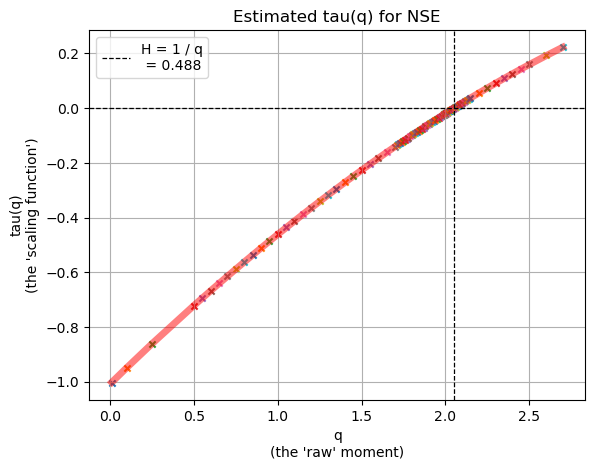


For NSE, we estimate
  𝜆 = 1.2359599413633282
  𝜎^2 = 0.6808364745066484


In [21]:
tau_q_ESTIMATED_NSE=0

tau_q_ESTIMATED_NSE=np.polyfit(q[0:max_q],tau_q_NSE[0:max_q],2)

for i in range(0,max_q):
    plt.scatter(q[i], (tau_q_ESTIMATED_NSE[0][0]*(q[i]**2) + tau_q_ESTIMATED_NSE[1][0]*q[i] + tau_q_ESTIMATED_NSE[2][0]), s = 20, marker='x')

plt.plot(q[0:max_q], tau_q_NSE[0:max_q], color="red",linewidth=5, alpha = 0.5)

plt.grid(visible=True)
plt.title("Estimated tau(q) for NSE")
plt.xlabel("q\n(the 'raw' moment)")
plt.axvline(1/H_NSE, color="black", linestyle='--', linewidth=0.9, label = "H = 1 / q\n = " + str(round(H_NSE, 3)))
plt.axhline(0, color="black", linestyle='--', linewidth=0.9)
plt.ylabel("tau(q)\n(the 'scaling function')")
plt.legend()
plt.show()

print("\nFor NSE, we estimate\n  𝜆 = " + str(lambda_NSE) + "\n  𝜎^2 = " + str(sigma_NSE))

In [22]:
from fbm import FBM,MBM
from fbm import fbm, fgn, mbm, mgn, times

import math

In [23]:
def lognormal_cascade(k, v,ln_lambda, ln_theta):

    k = k - 1

    m0 = np.random.lognormal(ln_lambda,ln_theta)
    m1 = np.random.lognormal(ln_lambda,ln_theta)
    M = [m0, m1]

    if (k >= 0):
        d=[0 for x in range(0,2)]
        for i in range(0,2):
            d[i] = lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)

        v = d

    return v


In [26]:
def MB(K, simulated_H, simulated_lambda, simulated_sigma, original_price_history, magnitude_parameter, GRAPHS):

    if GRAPHS == True:
        print("Performing an MMAR simulation with parameters:\n\nH = " + str(simulated_H) + "\nlambda = " + str(simulated_lambda) + "\nsigma = " + str(simulated_sigma) + "\nfBm magnitude = " + str(magnitude_parameter)+ "\n")

    new_cascade = list(np.array(lognormal_cascade(k=K, v=1, ln_lambda = simulated_lambda, ln_theta = simulated_sigma)).flat)
    if GRAPHS == True:
        plt.figure(figsize = (24,4))
        plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.title("Binomial Cascade")
        plt.xlabel("Conventional time\n(days)")
        plt.ylabel('"Mass"')
        plt.plot(new_cascade, color="crimson", linewidth=0.5)
        plt.show()


    # --- TRADING TIME ---
    tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)
    if GRAPHS == True:
        plt.figure(figsize = (24,4))
        plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.yticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.title("Trading time\n(normalized)")
        plt.xlabel("Conventional time\n(days)")
        plt.ylabel('"Trading time"\n(\u03B8 (t), normalized)')
        plt.plot(tradingtime, color="orangered")


    # --- FBM (Fractional Brownian Motion) ---
    new_fbm_class = FBM(n = 10*2**K+1, hurst = simulated_H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    if GRAPHS == True:
        plt.figure(figsize=(24,4))
        plt.xticks(np.arange(0, 10*2**(K)+1, 10*2**(K-3)))
        plt.title("Fractional Brownian Motion")
        plt.xlabel("t")
        plt.ylabel('fBm (t)')
        plt.plot(new_fbm_simulation, color="orange")
        plt.show()


    # --- MMAR XT's ---
    simulated_xt_array = [0 for x in range(0, len(tradingtime))]

    for i in range(0, len(tradingtime)):
        simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]

    simulated_price_array = original_price_history[-1]*np.exp(simulated_xt_array)



    if GRAPHS == True:
        plt.figure(figsize = (24,4))
        plt.title("MMAR generated Xt")
        plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.xlabel("Time\n(days)")
        plt.ylabel('X(t)\n(Natural log growth since beginning)')
        plt.grid(visible=True)
        plt.fill_between(np.arange(0, 2**K, 1) , simulated_xt_array, color="darkviolet", alpha=0.2)
        plt.show()


    # --- PRICES ---
    if GRAPHS == True:
        plt.figure(figsize = (24,4))
        plt.title("MMAR generated Price")
        plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.xlabel("Time\n(days)")
        plt.ylabel('Price level')
        plt.grid(visible=True)
        plt.fill_between(np.arange(0, 2**K, 1) , original_price_history[-1]*np.exp(simulated_xt_array), color="limegreen", alpha=0.2)
        plt.show()


    # --- LN CHANGES ---
    if GRAPHS == True:
        ln_simulated_xt_array = [0 for x in range(0, len(simulated_xt_array)-1)]

        for i in range(1,len(simulated_xt_array)):
            ln_simulated_xt_array[i-1] = np.log((original_price_history[0]*np.exp(simulated_xt_array[i]))/(original_price_history[0]*np.exp(simulated_xt_array[i-1])))

        plt.figure(figsize=(24,4))
        plt.title("Price increments")
        plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
        plt.xlabel("Time\n(days)")
        plt.ylabel('Change\n(%)')
        plt.grid(visible=True)
        plt.plot(ln_simulated_xt_array, color="darkviolet", linewidth=0.5)
        plt.gca().set_yticklabels(['{:.0f}'.format(x*100) for x in plt.gca().get_yticks()])
        plt.show()
        print("The number of price increments that equal zero is: " + str(list(np.abs(ln_simulated_xt_array)).count(0)))

    # --- END ---
    return simulated_price_array#simulated_xt_array

Performing an MMAR simulation with parameters:

H = 0.4875132647728514
lambda = 1.2359599413633282
sigma = 0.6808364745066484
fBm magnitude = 0.02



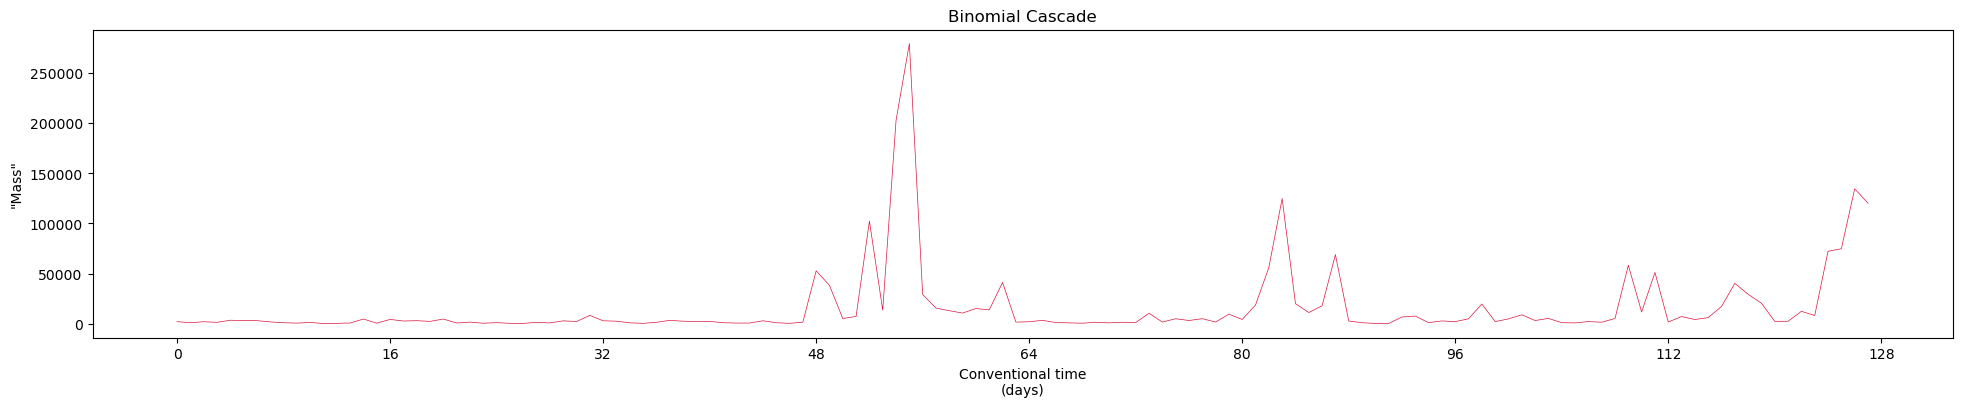

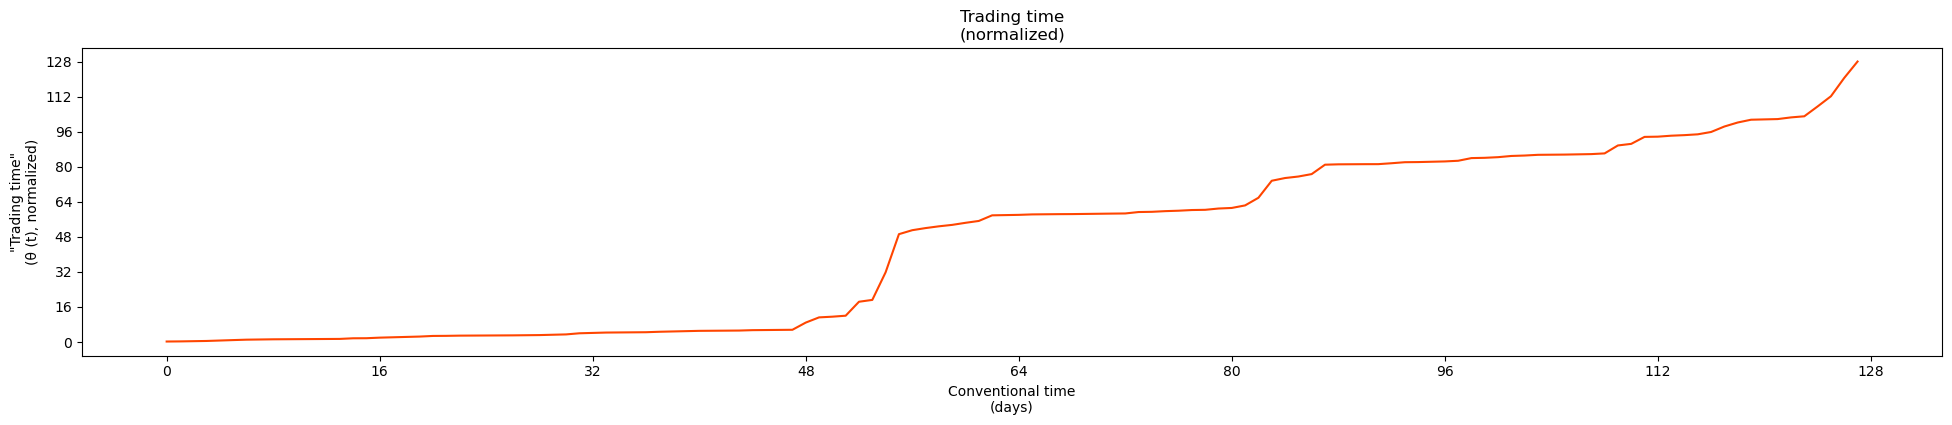

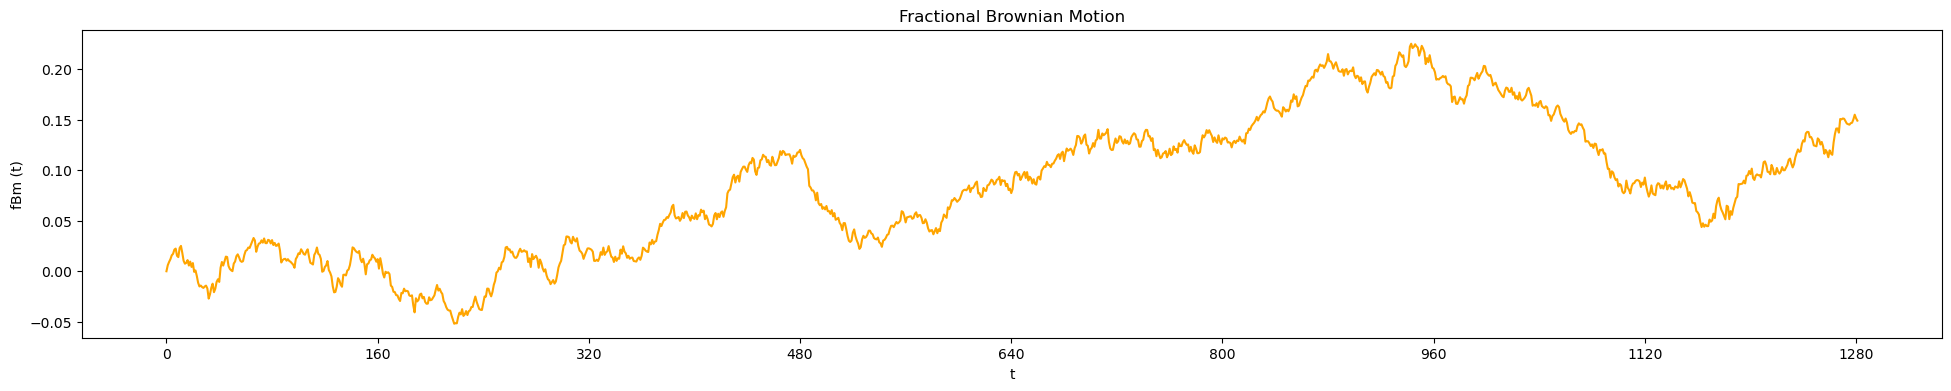

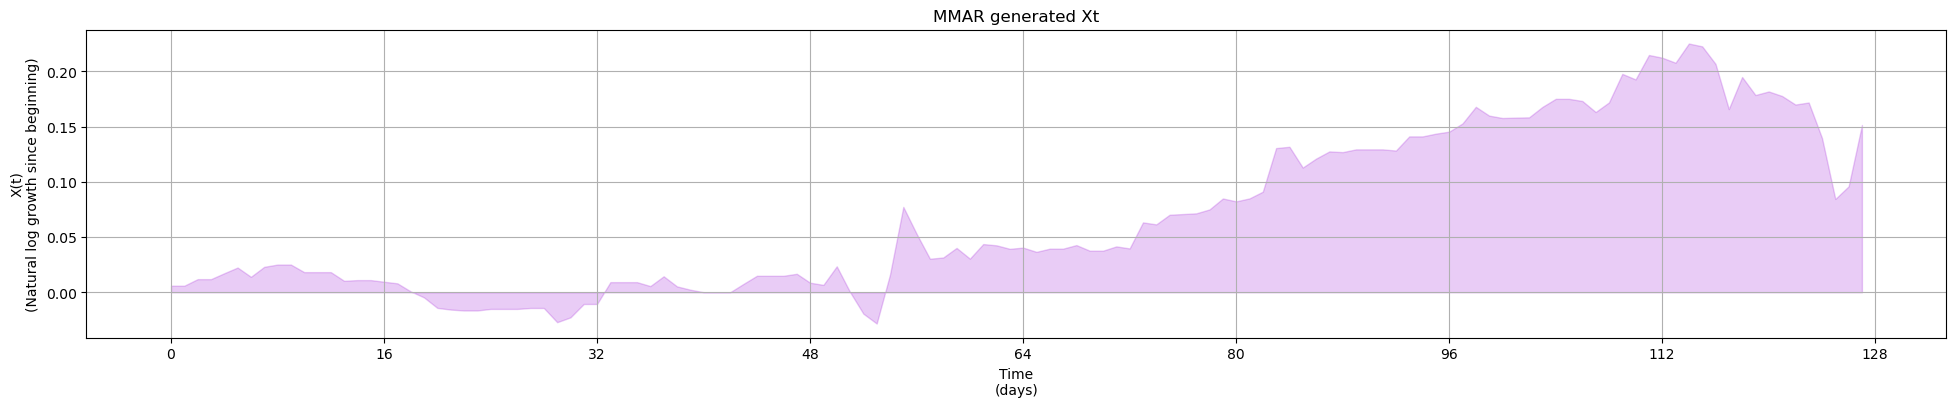

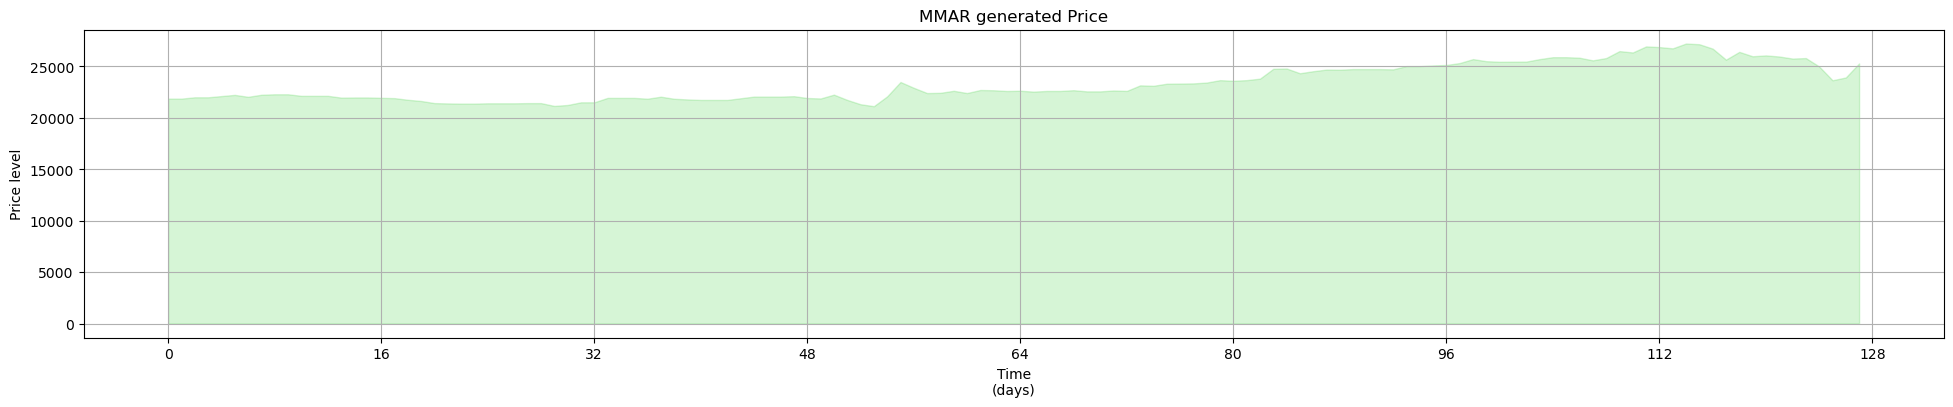

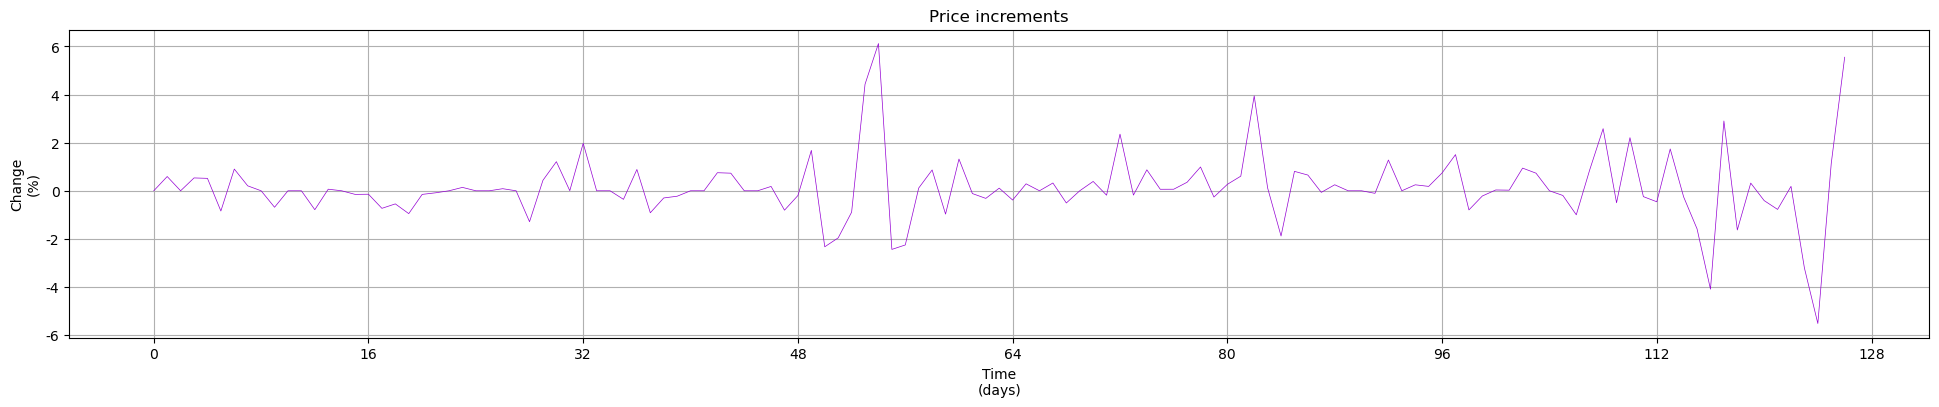

The number of price increments that equal zero is: 22


In [27]:
K = 7
MB_price_array = MB(K, H_NSE, lambda_NSE, sigma_NSE, df.Close, 0.02,True)

In [28]:
from IPython.display import clear_output

attempt_length = 10000

attempt=pd.DataFrame([0 for x in range(0,2**7)])

start_time = datetime.now().strftime("%I:%M%p")

magnitude_NSE = 0.02

for i in range(0,attempt_length):
    print("Having started at "+str(start_time))
    if i%(attempt_length/attempt_length)==0:
        print("Currently at i=" + str(i))
    if i%101==0:
        attempt[i] = pd.DataFrame(MB(K, H_NSE, lambda_NSE, sigma_NSE, df.Close, magnitude_NSE,False))
    else:
        attempt[i] = pd.DataFrame(MB(K, H_NSE, lambda_NSE, sigma_NSE, df.Close, magnitude_NSE,False))
    clear_output()

print("Having started at "+str(start_time))

attempt

Having started at 01:15AM


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,21639.259496,22129.403354,21731.400391,21562.547247,21610.952515,21876.948064,21870.526156,21827.014574,21882.828909,21731.400391,...,21751.644857,21365.882978,21781.726356,22001.558343,21638.613088,21833.084183,21731.400391,21825.313022,21620.569696,21808.775438
1,21830.288986,22428.472944,21762.026275,21315.071725,21707.946357,21908.147764,21046.999835,22031.816499,21764.735157,21731.400391,...,21666.386447,21105.315939,21579.018617,21863.269150,21690.206324,21749.030570,21709.284895,22091.084008,21851.789531,21607.078291
2,21628.879800,22360.845744,21762.026275,21468.121724,21701.552660,21908.147764,21330.374037,22025.741225,21275.455006,21606.690203,...,21542.989739,20691.026700,21475.604900,21783.320737,21649.603197,21749.030570,21760.987762,21941.425603,22074.907787,21668.475724
3,21690.246673,22557.443615,21762.026275,21428.132659,21382.748328,21865.692081,20175.065539,21837.075989,21283.268729,21606.690203,...,21677.851820,20753.418798,21518.822446,21864.278292,21649.603197,21736.662478,21492.885623,21756.816904,22298.718206,21448.855726
4,21191.767934,22609.920490,21759.350226,21524.175159,21449.779076,21848.643813,20118.198865,21557.450578,20803.679746,21463.416961,...,20845.571525,22249.740334,21582.586123,22454.053911,21700.652745,22061.435684,21475.020706,21725.708920,21752.821595,21377.603895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,19604.777277,25154.001296,25269.791920,25106.791334,23501.816326,21812.134443,20772.716162,18073.087994,17147.375911,17774.926819,...,18701.081436,17477.593217,25805.091717,22456.158291,27732.601341,19188.526829,16787.807809,20975.340744,21960.434241,20196.472772
124,19840.140130,25083.623979,25269.791920,25363.691333,24779.016387,21686.830352,21016.004892,18360.217400,17180.009953,17774.926819,...,18609.197001,17356.011729,25746.469270,22094.189720,27777.416461,19113.281384,16787.807809,21384.013553,22086.151792,20169.432061
125,20162.795209,24813.782158,25269.791920,25099.953007,24711.592331,21640.923581,21013.057665,18336.504144,17058.785659,17774.926819,...,18734.687101,17356.011729,25922.342884,22243.998286,27912.345054,19180.638139,16697.517990,21028.887840,21468.827142,20382.204969
126,20096.710983,24743.088076,25269.791920,25065.329501,24648.648941,21775.255330,21373.212352,19165.649828,17021.823128,17774.926819,...,17922.670487,17356.011729,25922.342884,22849.679229,27849.476386,19022.885818,16396.895474,20860.240871,21579.873144,20180.271769


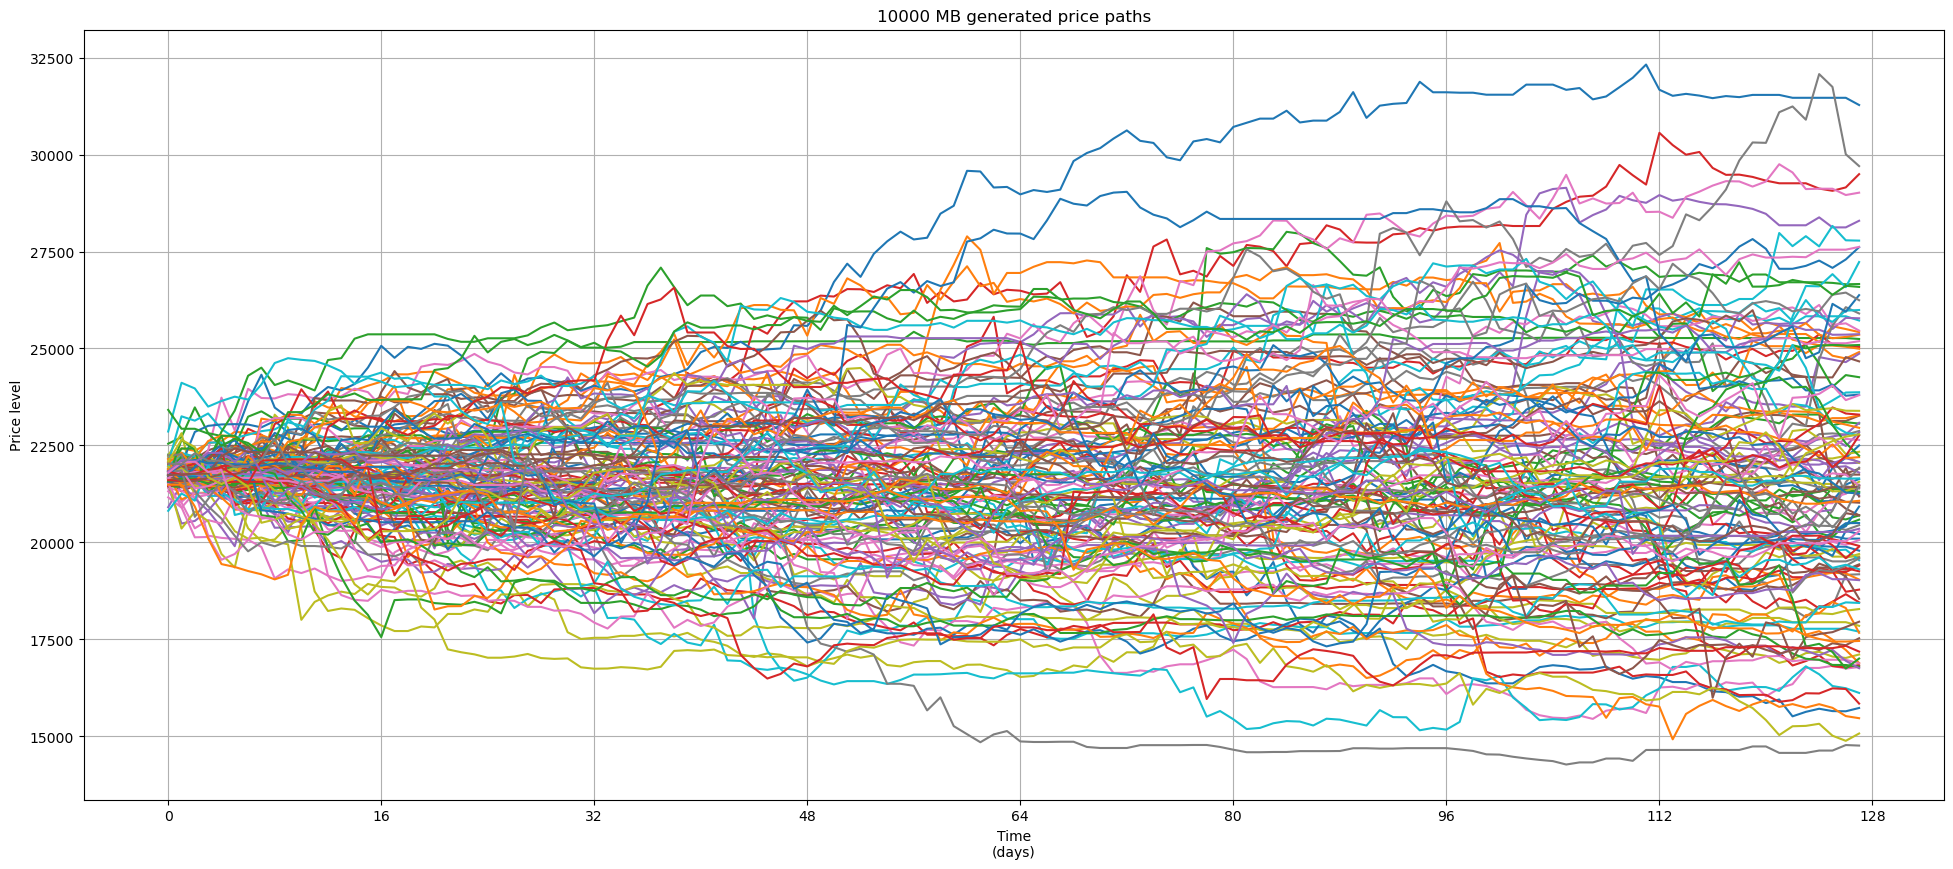

In [29]:
plt.figure(figsize = (24,10))

for i in range(len(attempt)):
    plt.title(str(attempt_length) + " MB generated price paths")
    plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
    plt.xlabel("Time\n(days)")
    plt.ylabel('Price level')
    plt.grid(visible = True)
    plt.plot(attempt[i])

plt.show()

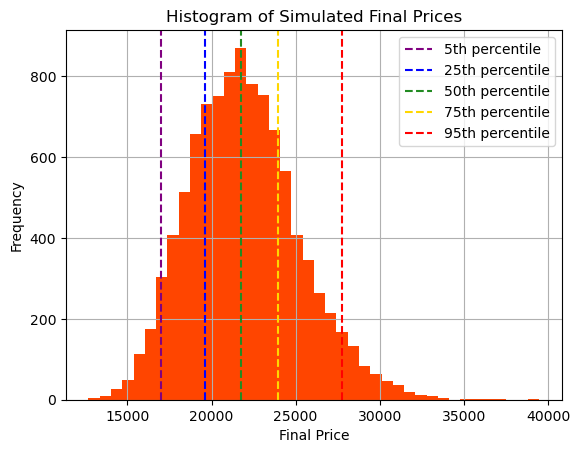

In [30]:
import matplotlib.pyplot as plt

plt.grid(visible=True)

plt.title("Histogram of Simulated Final Prices")
plt.hist(attempt.iloc[-1], bins=40, color="orangered")
plt.xlabel("Final Price")
plt.ylabel("Frequency")

# Plot percentile lines
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
colors = ["purple", "blue", "forestgreen", "gold", "red"]
labels = ["5th percentile", "25th percentile", "50th percentile", "75th percentile", "95th percentile"]

for percentile, color, label in zip(percentiles, colors, labels):
    plt.axvline(attempt.iloc[-1].quantile(percentile), linestyle='--', color=color, label=label)

plt.legend()
plt.show()


In [31]:
diff_attempt = [[0 for x in range(0,attempt_length)] for y in range (0,2**K)]
for i in range(0,attempt_length):
    for j in range (1,2**K):
        diff_attempt[j][i]=(attempt[i][j] - attempt[i][j-1])/(attempt[i][j-1])
    clear_output()

diff_attempt = pd.DataFrame(diff_attempt)


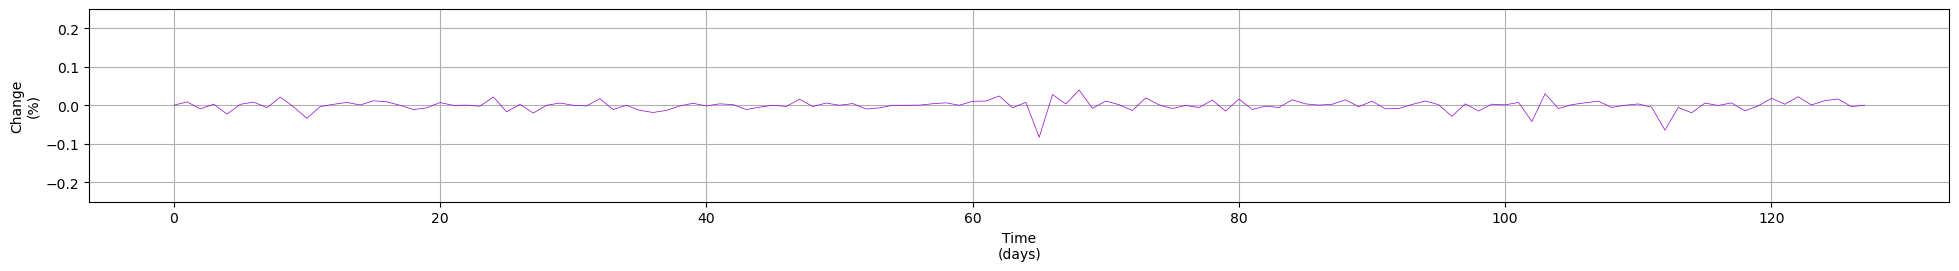

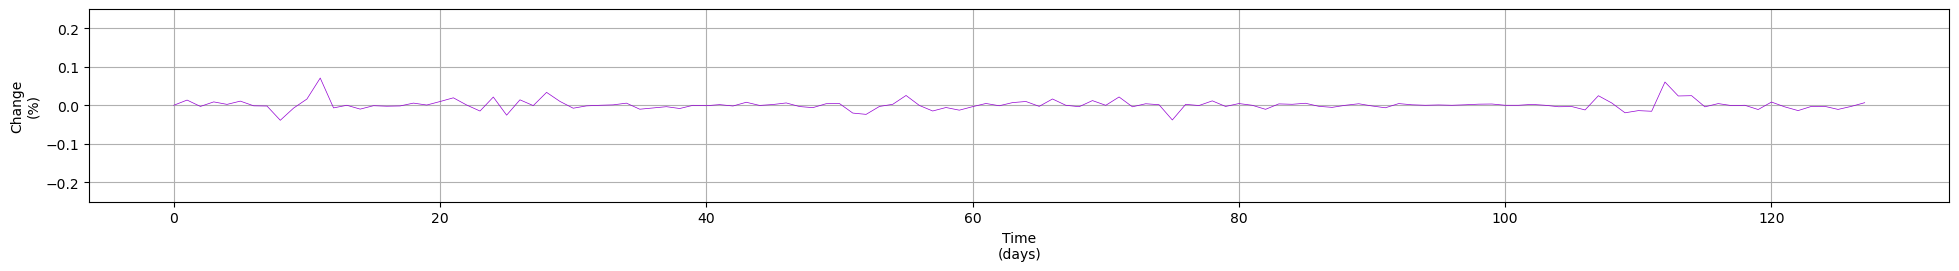

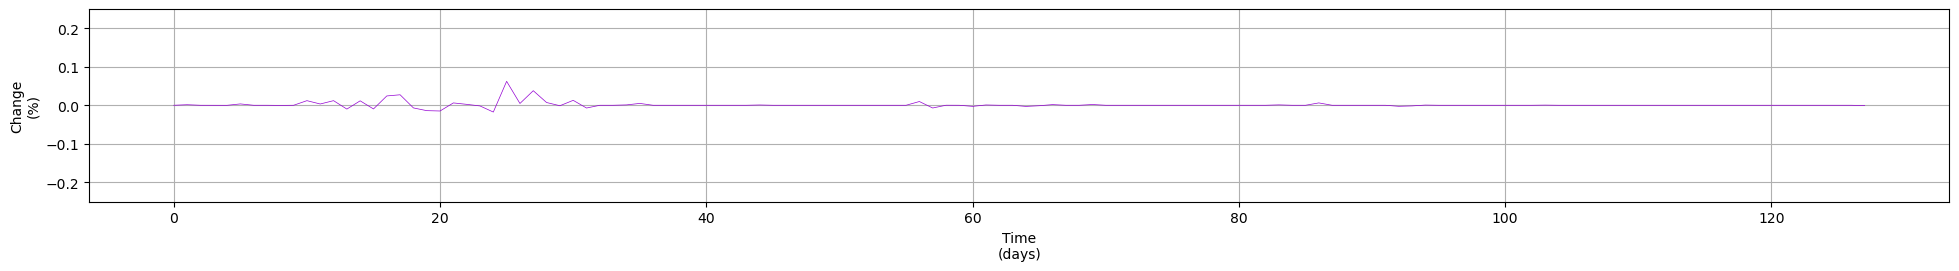

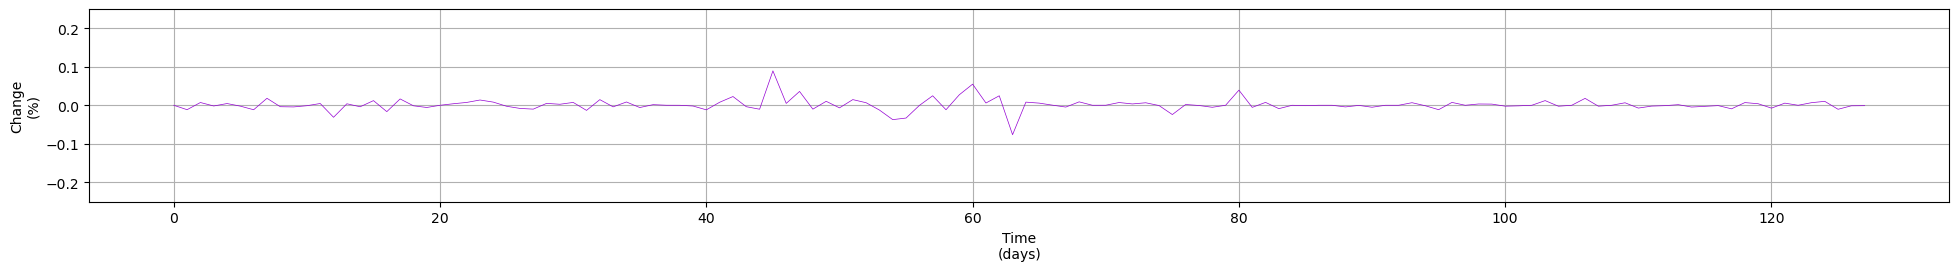

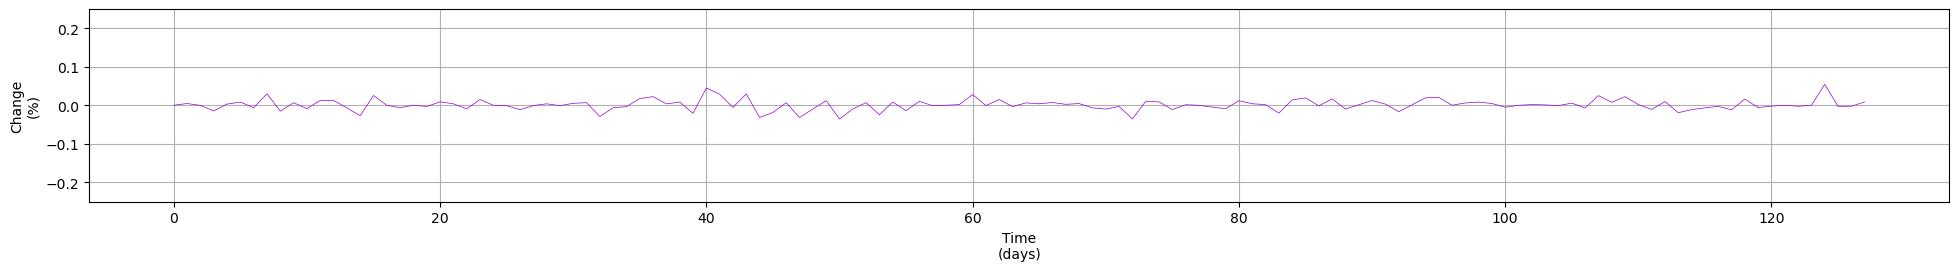

In [32]:
for i in range(0,5):
    plt.figure(figsize=(24,2.5))

    plt.xlabel("Time\n(days)")
    plt.grid(visible=True)
    plt.ylabel('Change\n(%)')

    axes = plt.gca()
    axes.set_ylim([-0.250,0.250])

    plt.plot(diff_attempt[i], color="darkviolet", linewidth=0.5)
    plt.show()

In [33]:
print("Here we can see some statistics about the price changes.\n")

df['Log Returns'].describe()

Here we can see some statistics about the price changes.



count    3781.000000
mean        0.000432
std         0.012809
min        -0.139038
25%        -0.005285
50%         0.000682
75%         0.006603
max         0.163343
Name: Log Returns, dtype: float64

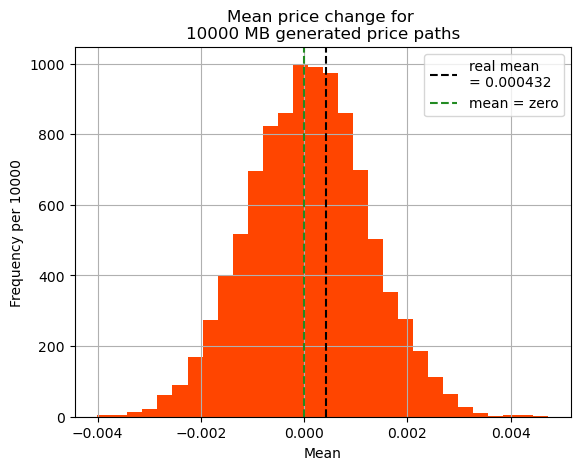

count    10000.000000
mean         0.000080
std          0.001152
min         -0.004004
25%         -0.000710
50%          0.000089
75%          0.000849
max          0.004726
dtype: float64


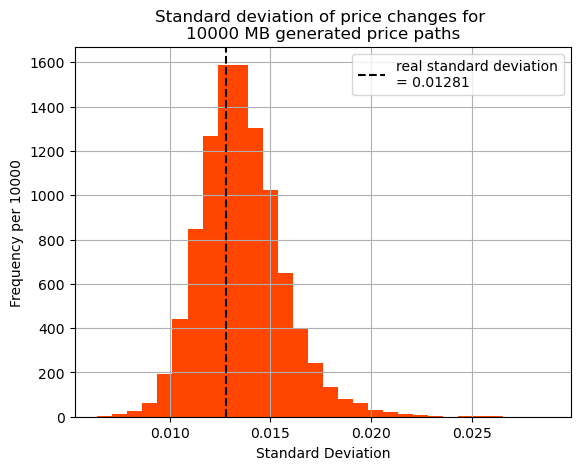



Below is a description of the standard deviations of our 10,000 simulations.



count    10000.000000
mean         0.013555
std          0.002065
min          0.006417
25%          0.012181
50%          0.013375
75%          0.014729
max          0.028768
dtype: float64

In [34]:
plt.grid(visible=True)
plt.title("Mean price change for \n" + str(attempt_length) + " MB generated price paths")
plt.hist(diff_attempt.mean(), bins=30, color='orangered')
plt.axvline(df['Log Returns'].mean(), linestyle='--', color="black", label="real mean\n= "+str(round(df['Log Returns'].mean(), 6)))
plt.axvline(0, linestyle='--', color="forestgreen", label="mean = zero")
plt.ylabel("Frequency per " + str(attempt_length))
plt.xlabel("Mean")
plt.legend()
plt.show()
print((diff_attempt.mean()).describe())

plt.grid(visible=True)
plt.title("Standard deviation of price changes for \n" + str(attempt_length) + " MB generated price paths")
plt.hist(diff_attempt.std(), bins=30, color='orangered')
plt.axvline(df['Log Returns'].std(), linestyle='--', color="black", label="real standard deviation\n= "+str(round(df['Log Returns'].std(), 5)))
plt.ylabel("Frequency per " + str(attempt_length))
plt.xlabel("Standard Deviation")
plt.legend()
plt.show()


print("\n\nBelow is a description of the standard deviations of our 10,000 simulations.\n")
(diff_attempt.std()).describe()

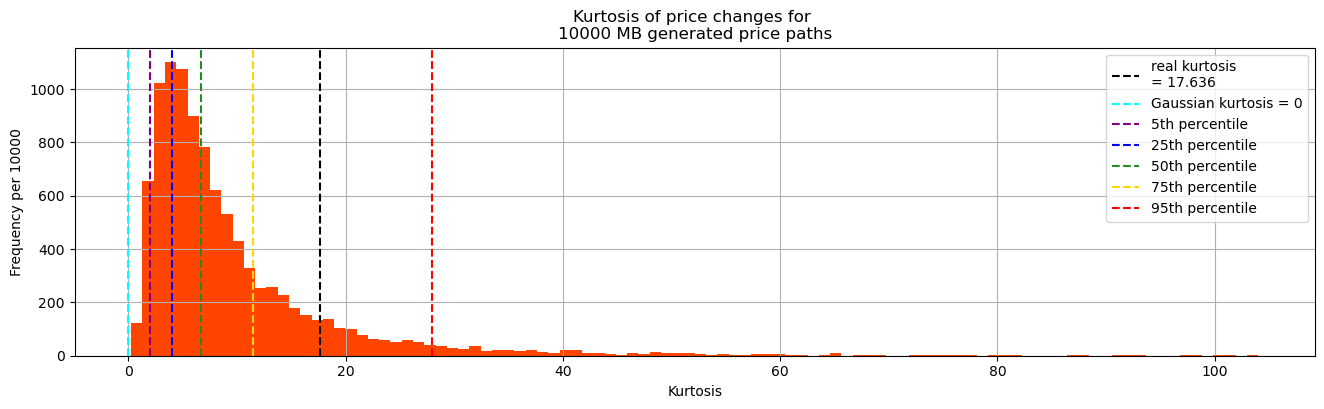

In [35]:
plt.figure(figsize=(16,4))
plt.grid(visible=True)
plt.title("Kurtosis of price changes for \n" + str(attempt_length) + " MB generated price paths")
plt.hist(stats.kurtosis(diff_attempt), bins=100, color='orangered')
plt.axvline(stats.kurtosis(df['Log Returns'][1:-1]), linestyle='--', color="black", label="real kurtosis\n= "+str(round(stats.kurtosis(df['Log Returns'][1:-1]), 3)))
plt.axvline(0, linestyle='--', color="aqua", label="Gaussian kurtosis = 0")

kurtosis_array_diff_attempt = stats.kurtosis(diff_attempt)
plt.axvline(np.quantile(kurtosis_array_diff_attempt, 0.05), linestyle='--', color="purple", label="5th percentile")
plt.axvline(np.quantile(kurtosis_array_diff_attempt,0.25), linestyle='--', color="blue", label="25th percentile")
plt.axvline(np.quantile(kurtosis_array_diff_attempt,0.5), linestyle='--', color="forestgreen", label="50th percentile")
plt.axvline(np.quantile(kurtosis_array_diff_attempt,0.75), linestyle='--', color="gold", label="75th percentile")
plt.axvline(np.quantile(kurtosis_array_diff_attempt,0.95), linestyle='--', color="red", label="95th percentile")

plt.ylabel("Frequency per " + str(attempt_length))
plt.xlabel("Kurtosis")
plt.legend()
plt.show()

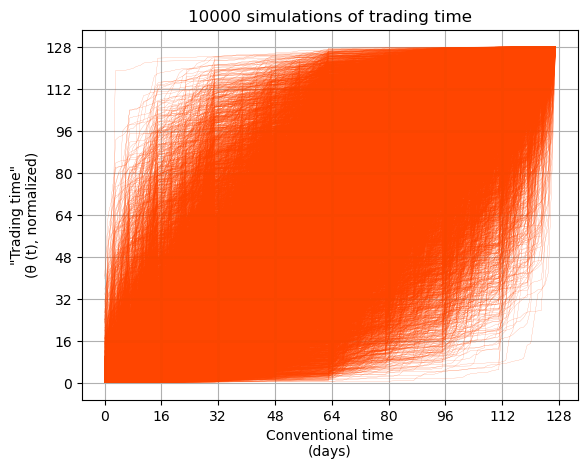

In [38]:
for i in range(0,10000):
    cherie = np.cumsum(lognormal_cascade(k=K, v=1, ln_lambda=lambda_NSE, ln_theta=sigma_NSE))
    cherie = 2**(K)*cherie/cherie[-1]
    plt.plot(cherie, linewidth=0.1, color="orangered")
plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
plt.yticks(np.arange(0, 2**(K)+1, 2**(K-3)))
plt.title("10000 simulations of trading time")
plt.xlabel("Conventional time\n(days)")
plt.ylabel('"Trading time"\n(\u03B8 (t), normalized)')
plt.grid(visible=True)
plt.show()

In [39]:
# Market params
T = 128.0/365.0   # maturity
S0 = 21730 # spot price
strike = 22200    # strike price
r = 0.0002   # risk-free interest rate
q = 0  # dividend rate

# initialize arrays
Vc_list = np.zeros(len(attempt)) # call array
Vp_list = np.zeros(len(attempt)) # put array

for i in range(len(attempt)):
    Vc_list[i] = np.exp(-r*T)*np.mean(np.maximum((attempt.iloc[i] - strike),0))
    Vp_list[i] = np.exp(-r*T)*np.mean(np.maximum((strike - attempt.iloc[i]),0))

In [40]:
Vc = np.mean(Vc_list)
Vp = np.mean(Vp_list)

print('The value of the call is: ' + str(round(Vc, 5)))
print('The value of the put is:  ' + str(round(Vp, 5)))

The value of the call is: 69.26838
The value of the put is:  105.25133
